# First 15 minutes Long-Short - Detection(Predict, Classification)

### Import Library

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [2]:
import os
from pathlib import Path
notebook_path = os.getcwd()
current_dir = Path(notebook_path)
csv_file = str(current_dir) + '/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [3]:
data = dataset.copy()

In [4]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2018-08-13 09:00:00,943.5,943.6,942.9,943.1,1812
2018-08-13 09:05:00,943.1,943.5,942.9,943.3,1323
2018-08-13 09:10:00,943.2,943.3,942.6,943.1,1207
2018-08-13 09:15:00,943.1,943.1,942.3,942.6,1196
2018-08-13 09:20:00,942.6,943.7,942.4,943.7,1765
...,...,...,...,...,...
2025-02-14 14:15:00,1343.0,1343.0,1340.3,1341.3,7141
2025-02-14 14:20:00,1340.9,1341.9,1340.5,1341.4,4593
2025-02-14 14:25:00,1341.1,1342.5,1340.7,1342.5,4207


In [9]:
_15m_data = data.copy().resample("15min").agg({
        'Open': 'first',
        'Close': 'last',
        'Low': 'min',
        'High': 'max',
        'Volume': 'sum'
    })

In [10]:
_15m_data

,Open,Close,Low,High,Volume
Date,,,,,
2018-08-13 09:00:00,943.5,943.1,942.6,943.6,4342
2018-08-13 09:15:00,943.1,945.3,942.3,945.9,5430
2018-08-13 09:30:00,945.2,944.5,943.3,945.5,4933
2018-08-13 09:45:00,944.5,946.0,944.3,946.4,4254
2018-08-13 10:00:00,945.9,945.2,944.5,946.3,4336
...,...,...,...,...,...
2025-02-14 13:45:00,1343.0,1343.1,1341.1,1343.6,14055
2025-02-14 14:00:00,1343.0,1343.1,1341.3,1344.2,9851
2025-02-14 14:15:00,1343.0,1342.5,1340.3,1343.0,15941


In [11]:
ato_data = _15m_data[(_15m_data.index.hour == 9) & (_15m_data.index.minute == 0)]

## Group data by Long-Short-None

In [13]:
def group_data(r):
    group = 0
    if r['Close'] > r['Open'] and r['Open'] - r['Low'] < 3.5:
        # group = 'long'
        group = 1
    elif r['Close'] < r['Open'] and r['High'] - r['Open'] < 3.5:
        # group = 'short'
        group = 2
    return group

In [14]:
ato_data['group'] = ato_data.apply(lambda r: group_data(r), axis=1)

<Axes: xlabel='group'>

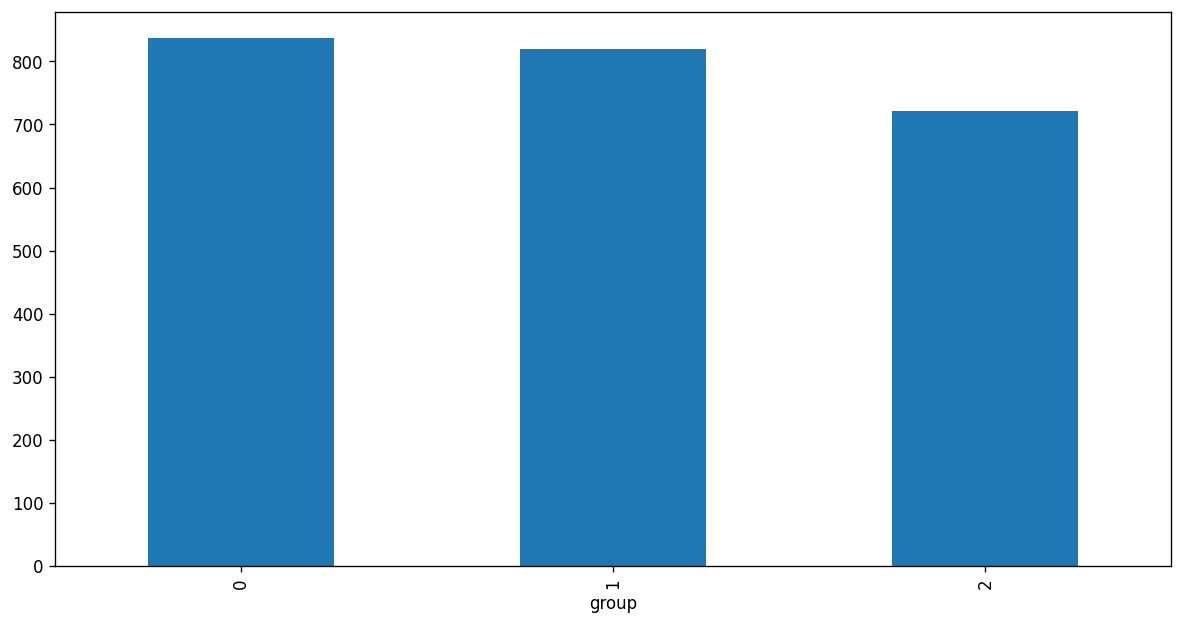

In [16]:
group_data = ato_data.groupby(['group'])['group'].count().rename({'group': 'count'})
group_data.plot.bar()